In [1]:
!pip install ultralytics boto3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.7/898.7 kB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 107.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 7.1 MB/s eta 0:00:00


In [2]:
import boto3
import botocore
from botocore.exceptions import ClientError
import os
from google.colab import userdata


os.environ['AWS_ACCESS_KEY_ID'] = userdata.get("AWS_ACCESS_KEY_ID")
os.environ['AWS_SECRET_ACCESS_KEY'] = userdata.get("AWS_SECRET_ACCESS_KEY")
os.environ['AWS_DEFAULT_REGION'] = 'us-east-1'

In [3]:
def download_from_s3(bucket, key, filename):
    try:
        s3.Bucket(bucket).download_file(key, filename)
    except botocore.exceptions.ClientError as e:
        if e.response['Error']['Code'] == "404":
            print("The object does not exist.")
        else:
            raise

In [4]:
s3 = boto3.resource('s3')
BUCKET = "sjsu-fall24-data298-team6-bucket"
download_from_s3(BUCKET, 'runs/yolo.zip', 'yolo_model.zip')
!unzip -q yolo_model.zip -d yolo_model

In [5]:
download_from_s3(BUCKET, 'runs/rtdetr.zip', 'rtdetr_model.zip')
!unzip -q rtdetr_model.zip -d rtdetr_model

In [6]:
download_from_s3(BUCKET, 'dataset/yolo.zip', 'data.zip')
!unzip -q data.zip -d data

In [7]:
from ultralytics import YOLO, RTDETR
import torch
from PIL import Image
import matplotlib.pyplot as plt

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [9]:
test_image = "/content/data/test/images/0000002_00005_d_0000014.jpg"
test_label = "/content/data/test/labels/0000002_00005_d_0000014.txt"

In [10]:
test_bbox = []
with open(test_label, 'r') as f:
    for line in f.readlines():
        parts = line.strip().split()
        class_id, x_center, y_center, width, height = map(float, parts)
        x_min = (x_center - width / 2)
        y_min = (y_center - height / 2)
        x_max = (x_center + width / 2)
        y_max = (y_center + height / 2)
        test_bbox.append([x_min, y_min, x_max, y_max])

100%|██████████| 5.35M/5.35M [00:00<00:00, 409MB/s]



image 1/1 /content/data/test/images/0000002_00005_d_0000014.jpg: 384x640 8 cars, 103.2ms
Speed: 14.7ms preprocess, 103.2ms inference, 812.1ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/data/test/images/0000002_00005_d_0000014.jpg: 384x640 1 pedestrian, 3 peoples, 50 cars, 5 vans, 1 truck, 1 tricycle, 1 awning-tricycle, 1 motor, 14.0ms
Speed: 2.1ms preprocess, 14.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


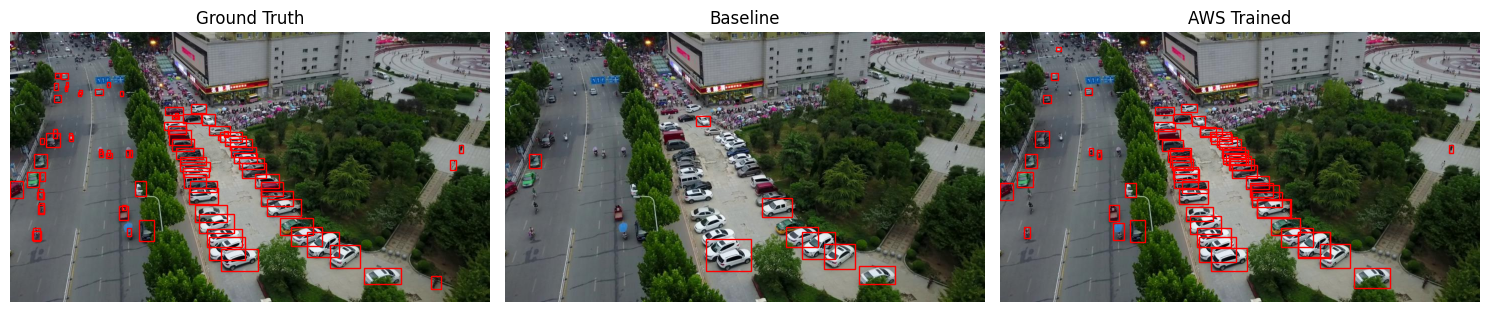

In [11]:
model = YOLO("yolo11n.pt")
base_pred = model.predict(source=test_image, conf=0.35)
base_bbox = base_pred[0].boxes.xyxy.tolist()

model = YOLO("/content/yolo_model/detect/train/weights/best.pt")
awsm_pred = model.predict(source=test_image, conf=0.35)
awsm_bbox = awsm_pred[0].boxes.xyxy.tolist()

img = Image.open(test_image)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(img)
ax[0].set_title("Ground Truth")
ax[1].imshow(img)
ax[1].set_title("Baseline")
ax[2].imshow(img)
ax[2].set_title("AWS Trained")
for box in test_bbox:
    x_min, y_min, x_max, y_max = box
    x_min, x_max = img.size[0] * x_min, img.size[0] * x_max
    y_min, y_max = img.size[1] * y_min, img.size[1] * y_max
    rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')
    ax[0].add_patch(rect)

for box in base_bbox:
    x_min, y_min, x_max, y_max = box
    rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')
    ax[1].add_patch(rect)

for box in awsm_bbox:
    x_min, y_min, x_max, y_max = box
    rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')
    ax[2].add_patch(rect)

ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
plt.tight_layout()
plt.show()

100%|██████████| 63.4M/63.4M [00:01<00:00, 41.9MB/s]



image 1/1 /content/data/test/images/0000002_00005_d_0000014.jpg: 640x640 10 persons, 15 cars, 10 motorcycles, 2 trucks, 70.6ms
Speed: 2.3ms preprocess, 70.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/data/test/images/0000002_00005_d_0000014.jpg: 640x640 30 pedestrians, 19 peoples, 2 bicycles, 47 cars, 6 vans, 1 tricycle, 1 awning-tricycle, 1 bus, 18 motors, 69.0ms
Speed: 2.5ms preprocess, 69.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


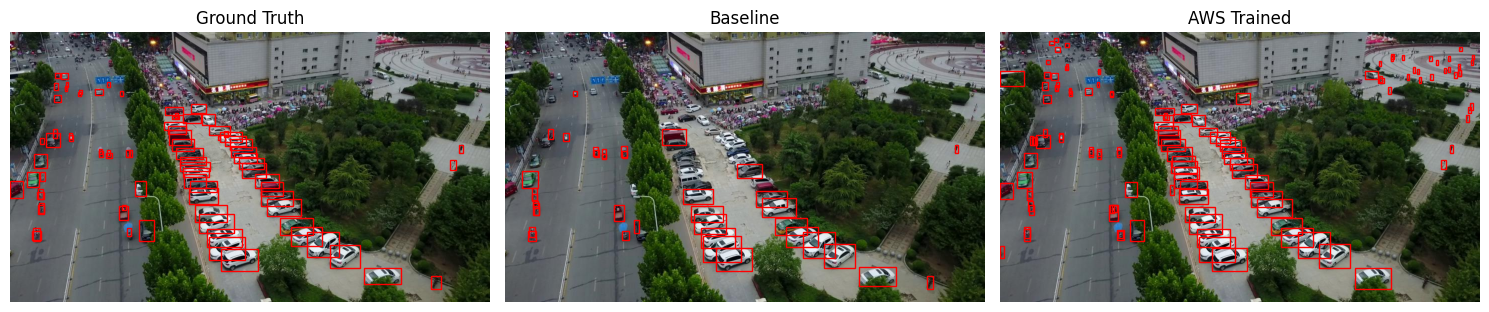

In [12]:
model = RTDETR("rtdetr-l.pt")
base_pred = model.predict(source=test_image, conf=0.35)
base_bbox = base_pred[0].boxes.xyxy.tolist()

model = RTDETR("/content/rtdetr_model/detect/train/weights/best.pt")
awsm_pred = model.predict(source=test_image, conf=0.35)
awsm_bbox = awsm_pred[0].boxes.xyxy.tolist()

img = Image.open(test_image)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(img)
ax[0].set_title("Ground Truth")
ax[1].imshow(img)
ax[1].set_title("Baseline")
ax[2].imshow(img)
ax[2].set_title("AWS Trained")
for box in test_bbox:
    x_min, y_min, x_max, y_max = box
    x_min, x_max = img.size[0] * x_min, img.size[0] * x_max
    y_min, y_max = img.size[1] * y_min, img.size[1] * y_max
    rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')
    ax[0].add_patch(rect)

for box in base_bbox:
    x_min, y_min, x_max, y_max = box
    rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')
    ax[1].add_patch(rect)

for box in awsm_bbox:
    x_min, y_min, x_max, y_max = box
    rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')
    ax[2].add_patch(rect)

ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
plt.tight_layout()
plt.show()